## INTERPOLATION

#### Sample json-like data

In [260]:
tp = [
	{ "name": "tp", "value": -6.535714003820189, "date": "2021-12-01" },
	{ "name": "tp", "value": -6.635714003820189, "date": "2022-01-01" },
	{ "name": "tp", "value": -8.2562604611191, "date": "2022-02-01" },
	{ "name": "tp", "value": 17.944730966895197, "date": "2022-03-01" },
	{ "name": "tp", "value": 14.303208732468846, "date": "2022-04-01" },
	{ "name": "tp", "value": -2.0903878778233542, "date": "2022-05-01" },
	{ "name": "tp", "value": 0.021677844788595024, "date": "2022-06-01" },
	{ "name": "tp", "value": 13.713199316919699, "date": "2022-07-01" },
	{ "name": "tp", "value": 29.79808955209314, "date": "2022-08-01" },
	{ "name": "tp", "value": 36.553224892081765, "date": "2022-09-01" },
	{ "name": "tp", "value": 33.1448253022692, "date": "2022-10-01" },
	{ "name": "tp", "value": 29.966342481452266, "date": "2022-11-01" },
	{ "name": "tp", "value": 32.90944466755932, "date": "2022-12-01" }
]

values = [data['value'] for data in tp]

min_val = min(values)
max_val = max(values)

normalized_values = [(val - min_val) / (max_val - min_val) for val in values]

for i, entry in enumerate(tp):
    entry['value'] = normalized_values[i]

In [261]:
import random
import pandas as pd

t2m = []
date_range = pd.date_range(start='1/1/2022', end='31/12/2022')

for day in range(1, 366):
    value = round(random.uniform(-10, 10), 6)
    date = date_range[day - 1].strftime('%Y-%m-%d')
    entry = {"name": "t2m", "value": value, "date": date}
    t2m.append(entry)

values = [data['value'] for data in t2m]

min_val = min(values)
max_val = max(values)

normalized_values = [(val - min_val) / (max_val - min_val) for val in values]

for i, entry in enumerate(t2m):
    entry['value'] = normalized_values[i]


#### JSON to Time Series

In [281]:
import pandas as pd
from collections import defaultdict
from datetime import datetime

def find_earliest_latest_date(*variables):
    earliest_date = None
    latest_date = None
    for var in variables:
        for item in var:
            date = item['date']
            if earliest_date is None or date < earliest_date:
                earliest_date = date
            if latest_date is None or date > latest_date:
                latest_date = date
    return earliest_date, latest_date

def time_series_daily(*variables):
    earliest_date, latest_date = find_earliest_latest_date(*variables)
    dates = pd.date_range(start=earliest_date, end=latest_date)
    result = []
    for date in dates:
        entry = {'date': date.strftime('%Y-%m-%d')}
        for variable in variables:
            value = None
            for item in variable:
                if item['date'] == date.strftime('%Y-%m-%d'):
                    value = item['value']
                    break
            entry[variable[0]['name']] = value
        result.append(entry)
    return result

def time_series_monthly(*variables):
    earliest_date, latest_date = find_earliest_latest_date(*variables)
    earliest = datetime.strptime(earliest_date, '%Y-%m-%d')
    latest = datetime.strptime(latest_date, '%Y-%m-%d')

    monthly_data = defaultdict(list)

    while earliest <= latest:
        year_month = earliest.strftime('%B %Y')
        
        data_for_date = {}
        for variable in variables:
            for item in variable:
                if item['date'] == earliest.strftime('%Y-%m-%d'):
                    data_for_date[variable[0]['name']] = item['value']
            if variable[0]['name'] not in data_for_date:
                data_for_date[variable[0]['name']] = None

        monthly_data[year_month].append(data_for_date)

        earliest = earliest + pd.DateOffset(months=1)

    result = []
    for year_month, data in monthly_data.items():
        entry = {'date': year_month}
        for variable in data[0]:
            values = [d[variable] for d in data if variable in d]
            if all(value is not None for value in values):
                entry[variable] = sum(values) / len(values)
            else:
                entry[variable] = None
        result.append(entry)

    return result

def time_series_yearly(*variables):
    earliest_date, latest_date = find_earliest_latest_date(*variables)
    earliest = datetime.strptime(earliest_date, '%Y-%m-%d')
    latest = datetime.strptime(latest_date, '%Y-%m-%d')

    yearly_data = defaultdict(list)

    while earliest <= latest:
        year = earliest.strftime('%Y')

        data_for_date = {}
        for variable in variables:
            for item in variable:
                if item['date'] == earliest.strftime('%Y-%m-%d'):
                    data_for_date[variable[0]['name']] = item['value']
            if variable[0]['name'] not in data_for_date:
                data_for_date[variable[0]['name']] = None

        yearly_data[year].append(data_for_date)

        earliest = earliest + pd.DateOffset(years=1)

    result = []
    for year, data in yearly_data.items():
        entry = {'date': year}
        for variable in data[0]:
            values = [d[variable] for d in data if variable in d]
            if all(value is not None for value in values):
                entry[variable] = sum(values) / len(values)
            else:
                entry[variable] = None
        result.append(entry)

    return result

result = time_series_daily(tp, t2m)
# result = time_series_monthly(tp, t2m)
# result = time_series_yearly(tp)

#### Interpolation process

In [283]:
variables_to_interpolate = ['tp', 't2m']

for variable in variables_to_interpolate:
    x1, x2, y1, y2 = None, None, None, None
    for i, data in enumerate(result):
        if data[variable] is not None:
            if x1 is None:
                x1 = i
                y1 = data[variable]
            else:
                x2 = i
                y2 = data[variable]
                for j in range(x1 + 1, x2):
                    result[j][variable] = y1 + (j - x1) * ((y2 - y1) / (x2 - x1))
                x1, x2, y1, y2 = i, None, data[variable], None


#### Check interpolation graph

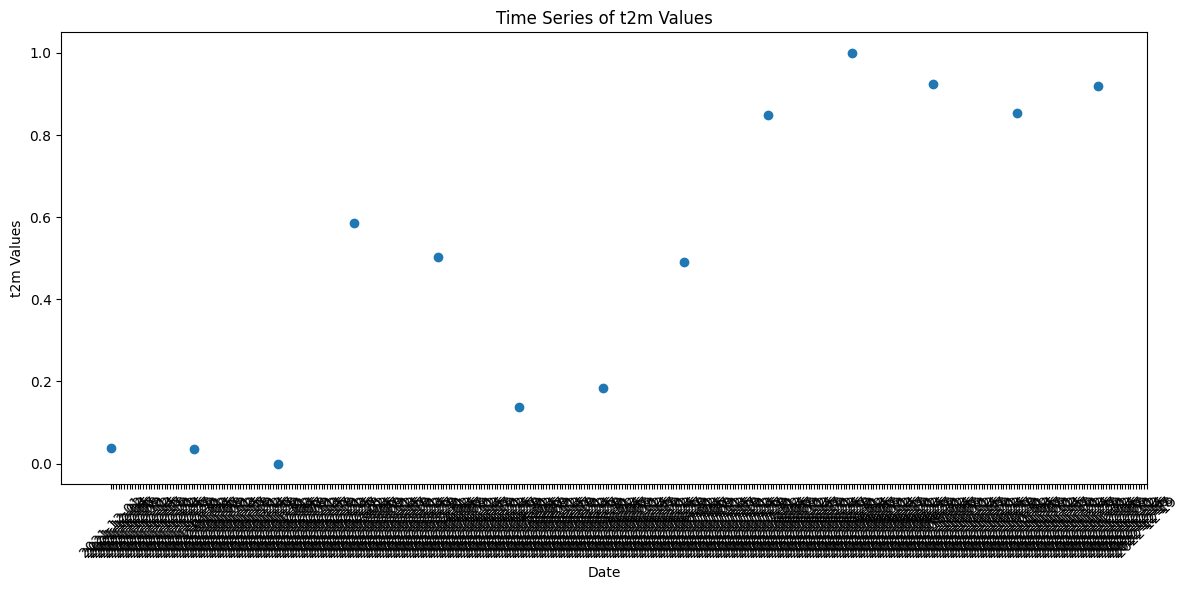

In [282]:
import matplotlib.pyplot as plt

dates = [entry['date'] for entry in result]
tp_values = [entry['tp'] if entry['tp'] is not None else float('nan') for entry in result]
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dates, tp_values, marker='o', linestyle='-')
ax.set_xlabel('Date')
ax.set_ylabel('t2m Values')
ax.set_title('Time Series of t2m Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()